# Snippets and Exercises
With help from: 
https://github.com/dodafin/advances-in-financial-ml-notes/blob/master/Chapter%2008%20-%20Feature%20Importance.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

### SNIPPET 7.3 CROSS-VALIDATION CLASS WHEN OBSERVATIONS OVERLAP

In [2]:
from sklearn.model_selection import KFold
class PurgedKFold(KFold):
    #Extend KFold class to work with labels that span intervals
    #The train is purged of observations overlapping test-label intervals
    #Test set is assumed contiguous (shuffle=False), w/o training samples in between 
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None) 
        self.t1=t1
        self.pctEmbargo=pctEmbargo
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index') 
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in \
            np.array_split(np.arange(X.shape[0]),self.n_splits)] 
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j] 
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max()) 
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index) 
            if maxT1Idx<X.shape[0]: # right train (with embargo)
                train_indices=np.concatenate((train_indices,indices[maxT1Idx+mbrg:])) 
            yield train_indices,test_indices

### SNIPPET 7.4 USING THE PurgedKFold CLASS

In [3]:
from sklearn.metrics import log_loss,accuracy_score 
# from clfSequential import PurgedKFold
    
def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None, pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']: 
        raise Exception('wrong scoring method.')
    if cvGen is None:
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged 
    score=[]
    for train,test in cvGen.split(X=X): 
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],sample_weight=sample_weight.iloc[train].values) 
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[test,:]) 
            score_=-log_loss(y.iloc[test],prob, sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[test,:]) 
            score_=accuracy_score(y.iloc[test],pred,sample_weight= \
                sample_weight.iloc[test].values) 
            score.append(score_)
    return np.array(score)

### SNIPPET 8.2 MDI FEATURE IMPORTANCE

In [4]:
def featImpMDI(fit,featNames):
    # feat importance based on IS mean impurity reduction
    df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)} 
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),'std':df0.std()*df0.shape[0]**-.5},axis=1) 
    imp/=imp['mean'].sum()
    return imp

### SNIPPET 8.3 MDA FEATURE IMPORTANCE

In [5]:
from sklearn.metrics import log_loss,accuracy_score 

def featImpMDA(clf,X,y,cv,sample_weight,t1,pctEmbargo,scoring='neg_log_loss'): 
    '''    
    feat importance based on OOS score reduction
    '''    
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    
    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv 
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)

    for i,(train,test) in enumerate(cvGen.split(X=X)): 
        X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train] 
        X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test] 
        fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1) 
            scr0.loc[i]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
        else:
            pred=fit.predict(X1) 
            scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column 
            if scoring=='neg_log_loss':
                prob=fit.predict_proba(X1_) 
                scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=w1.values,labels=clf.classes_)
            else:
                pred=fit.predict(X1_) 
                scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)
    imp=(-scr1).add(scr0,axis=0)
    if scoring=='neg_log_loss':
        imp=imp/-scr1
    else:
        imp=imp/(1.-scr1) 
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1) 
    return imp,scr0.mean()

### SNIPPET 8.4 IMPLEMENTATION OF SFI

In [6]:
def auxFeatImpSFI(featNames,clf,trnsX,cont,scoring,cvGen): 
    imp=pd.DataFrame(columns=['mean','std'])
    for featName in featNames:
        df0=cvScore(clf,X=trnsX[[featName]],y=cont['bin'],sample_weight=cont['w'], scoring=scoring,cvGen=cvGen)
        imp.loc[featName,'mean']=df0.mean()
        imp.loc[featName,'std']=df0.std()*df0.shape[0]**-.5 
    return imp

### SNIPPET 8.5 COMPUTATION OF ORTHOGONAL FEATURES

In [7]:
def get_eVec(dot,varThres):
    '''compute eVec from dot prod matrix, reduce dimension'''
    eVal,eVec=np.linalg.eigh(dot)
    idx=eVal.argsort()[::-1] # arguments for sorting eVal desc 
    eVal,eVec=eVal[idx],eVec[:,idx]
    #2) only positive eVals
    eVal=pd.Series(eVal,index=['PC_'+str(i+1) for i in range(eVal.shape[0])]) 
    eVec=pd.DataFrame(eVec,index=dot.index,columns=eVal.index) 
    eVec=eVec.loc[:,eVal.index]
    #3) reduce dimension, form PCs
    cumVar=eVal.cumsum()/eVal.sum()
    dim=cumVar.values.searchsorted(varThres) 
    eVal,eVec=eVal.iloc[:dim+1],eVec.iloc[:,:dim+1]
    return eVal,eVec

def orthoFeats(dfX,varThres=.95):
    '''Given a dataframe dfX of features, compute orthofeatures dfP '''
    dfZ=dfX.sub(dfX.mean(),axis=1).div(dfX.std(),axis=1) # standardize 
    dot=pd.DataFrame(np.dot(dfZ.T,dfZ),index=dfX.columns,columns=dfX.columns) 
    eVal,eVec=get_eVec(dot,varThres)
    dfP=np.dot(dfZ,eVec) 
    return dfP

### SNIPPET 8.6 COMPUTATION OF WEIGHTED KENDALL’S TAU BETWEEN FEATURE IMPORTANCE AND INVERSE PCA RANKING

In [8]:
import numpy as np
from scipy.stats import weightedtau
featImp=np.array([.55,.33,.07,.05]) # feature importance 
pcRank=np.array([1,2,4,3]) # PCA rank
weightedtau(featImp,pcRank**-1.)[0]

0.8133333333333331

### SNIPPET 8.7 CREATING A SYNTHETIC DATASET

In [9]:
from sklearn.datasets import make_classification 

def getTestData(n_features=40,n_informative=10,n_redundant=10,n_samples=10000): 
    '''generate a random dataset for a classification problem'''
    trnsX,cont=make_classification(n_samples=n_samples,n_features=n_features,
                                   n_informative=n_informative,n_redundant=n_redundant,random_state=0,
                                   shuffle=False) 
    df0=pd.DatetimeIndex(periods=n_samples,freq=pd.tseries.offsets.BDay(),
                         end=pd.datetime.today()) 
    trnsX,cont=pd.DataFrame(trnsX,index=df0),pd.Series(cont,index=df0).to_frame('bin') 
    df0=['I_'+str(i) for i in xrange(n_informative)]+['R_'+str(i) for i in xrange(n_redundant)] 
    df0+=['N_'+str(i) for i in xrange(n_features-len(df0))] 
    trnsX.columns=df0
    cont['w']=1./cont.shape[0] 
    cont['t1']=pd.Series(cont.index,index=cont.index) 
    return trnsX,cont

### SNIPPET 8.8 CALLING FEATURE IMPORTANCE FOR ANY METHOD

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj as mpPandasObj

def featImportance(trnsX,cont,n_estimators=1000,cv=10,max_samples=1.,numThreads=24, pctEmbargo=0,scoring='accuracy',method='SFI',minWLeaf=0.,**kargs):
    '''feature importance from a random forest'''
    n_jobs=(-1 if numThreads>1 else 1) # run 1 thread with ht_helper in dirac1 
    #1) prepare classifier,cv. max_features=1, to prevent masking 
    clf=DecisionTreeClassifier(criterion='entropy',max_features=1,class_weight='balanced',min_weight_fraction_leaf=minWLeaf) 
    clf=BaggingClassifier(base_estimator=clf,n_estimators=n_estimators,max_features=1.,max_samples=max_samples,oob_score=True,n_jobs=n_jobs) 
    fit=clf.fit(X=trnsX,y=cont['bin'],sample_weight=cont['w'].values) 
    oob=fit.oob_score_
    if method=='MDI':
        imp=featImpMDI(fit,featNames=trnsX.columns) 
        oos=cvScore(clf,X=trnsX,y=cont['bin'],cv=cv,sample_weight=cont['w'],
                    t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring).mean() 
    elif method=='MDA':
        imp,oos=featImpMDA(clf,X=trnsX,y=cont['bin'],cv=cv,sample_weight=cont['w'], 
                           t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring)
    elif method=='SFI': 
        cvGen=PurgedKFold(n_splits=cv,t1=cont['t1'],pctEmbargo=pctEmbargo) 
        oos=cvScore(clf,X=trnsX,y=cont['bin'],sample_weight=cont['w'],scoring=scoring,
                    cvGen=cvGen).mean()
        clf.n_jobs=1 # paralellize auxFeatImpSFI rather than clf 
        imp=mpPandasObj(auxFeatImpSFI,('featNames',trnsX.columns),numThreads,
                        clf=clf,trnsX=trnsX,cont=cont,scoring=scoring,cvGen=cvGen) 
    return imp,oob,oos

### SNIPPET 8.9 CALLING ALL COMPONENTS

In [11]:
def testFunc(n_features=40,n_informative=10,n_redundant=10,n_estimators=1000, n_samples=10000,cv=10):
    # test the performance of the feat importance functions on artificial data 
    # Nr noise features = n_features—n_informative—n_redundant 
    trnsX,cont=getTestData(n_features,n_informative,n_redundant,n_samples)
    dict0={'minWLeaf':[0.],'scoring':['accuracy'],'method':['MDI','MDA','SFI'], 'max_samples':[1.]}
    jobs,out=(dict(izip(dict0,i)) for i in product(*dict0.values())),[] 
    kargs={'pathOut':'./testFunc/','n_estimators':n_estimators,
            'tag':'testFunc','cv':cv}
    for job in jobs:
        job['simNum']=job['method']+'_'+job['scoring']+'_'+'%.2f'%job['minWLeaf']+'_'+str(job['max_samples'])
        print(job['simNum'])
        kargs.update(job) 
        imp,oob,oos=featImportance(trnsX=trnsX,cont=cont,**kargs) 
        plotFeatImportance(imp=imp,oob=oob,oos=oos,**kargs) 
        df0=imp[['mean']]/imp['mean'].abs().sum() 
        df0['type']=[i[0] for i in df0.index] 
        df0=df0.groupby('type')['mean'].sum().to_dict() 
        df0.update({'oob':oob,'oos':oos});df0.update(job) 
        out.append(df0)
    out=pd.DataFrame(out).sort_values(['method','scoring','minWLeaf','max_samples']) 
    out=out['method','scoring','minWLeaf','max_samples','I','R','N','oob','oos'] 
#     out.to_csv(kargs['pathOut']+'stats.csv')
    return

### SNIPPET 8.10 FEATURE IMPORTANCE PLOTTING FUNCTION

In [44]:
def plotFeatImportance(pathOut,imp,oob,oos,method,tag=0,simNum=0,**kargs): 
    '''plot mean imp bars with std'''
    plt.figure(figsize=(10,imp.shape[0]/5.)) 
    imp=imp.sort_values('mean',ascending=True) 
    ax=imp['mean'].plot(kind='barh',color='b',alpha=.25,xerr=imp['std'],error_kw={'ecolor':'r'})
    if method=='MDI':
        plt.xlim([0,imp.sum(axis=1).max()]) 
        plt.axvline(1./imp.shape[0],linewidth=1,color='r',linestyle='dotted')
    ax.get_yaxis().set_visible(False)
    for i,j in zip(ax.patches,imp.index):
        ax.text(i.get_width()/2, i.get_y()+i.get_height()/2,j,ha='center',va='center',
                color='black')
    plt.title('tag='+str(tag)+' | simNum='+str(simNum)+' | oob='+str(round(oob,4))+
    ' | oos='+str(round(oos,4))) 
#     plt.savefig(pathOut+'featImportance_'+str(simNum)+'.png',dpi=100) 
#     plt.clf();plt.close()
    plt.show()
    return

## Exercises

## 1. Using the code presented in Section 8.6:

### a) Generate a dataset (X, y).

In [51]:
from sklearn.datasets import make_classification 
from datetime import datetime

def getTestData(n_features=9,n_informative=3,n_redundant=3,n_samples=1000): 
    '''generate a random dataset for a classification problem'''
    trnsX,cont=make_classification(n_samples=n_samples,n_features=n_features,
                                   n_informative=n_informative,n_redundant=n_redundant,random_state=0,
                                   shuffle=False) 
    df0=pd.date_range(periods=n_samples,freq=pd.tseries.offsets.BDay(),
                         end=datetime.today()) 
    trnsX,cont=pd.DataFrame(trnsX,index=df0),pd.Series(cont,index=df0).to_frame('bin') 
    df0=['I_'+str(i) for i in range(n_informative)]+['R_'+str(i) for i in range(n_redundant)] 
    df0+=['N_'+str(i) for i in range(n_features-len(df0))] 
    trnsX.columns=df0
    cont['w']=1./cont.shape[0] 
    cont['t1']=pd.Series(cont.index,index=cont.index) 
    return trnsX,cont

In [69]:
X, cont = getTestData(n_samples=1000)

In [71]:
X.to_csv("../data/x.csv")

In [72]:
cont.to_csv("../data/cont.csv")

### b) Apply a PCA transformation on X, which we denote X-dot.

In [55]:
def get_eVec(dot,varThres):
    '''compute eVec from dot prod matrix, reduce dimension'''
    eVal,eVec=np.linalg.eigh(dot)
    idx=eVal.argsort()[::-1] # arguments for sorting eVal desc 
    eVal,eVec=eVal[idx],eVec[:,idx]
    #2) only positive eVals
    eVal=pd.Series(eVal,index=['PC_'+str(i+1) for i in range(eVal.shape[0])]) 
    eVec=pd.DataFrame(eVec,index=dot.index,columns=eVal.index) 
    eVec=eVec.loc[:,eVal.index]
    #3) reduce dimension, form PCs
    cumVar=eVal.cumsum()/eVal.sum()
    dim=cumVar.values.searchsorted(varThres) 
    eVal,eVec=eVal.iloc[:dim+1],eVec.iloc[:,:dim+1]
    return eVal,eVec

def orthoFeats(dfX,varThres=.95):
    '''Given a dataframe dfX of features, compute orthofeatures dfP '''
    dfZ=dfX.sub(dfX.mean(),axis=1).div(dfX.std(),axis=1) # standardize 
    dot=pd.DataFrame(np.dot(dfZ.T,dfZ),index=dfX.columns,columns=dfX.columns) 
    eVal,eVec=get_eVec(dot,varThres)
    dfP=np.dot(dfZ,eVec) 
    return dfP

In [56]:
Xdot = pd.DataFrame(orthoFeats(X), index=X.index).add_prefix("PCA_")
Xdot.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
2017-09-04 09:09:38.028270,-3.341057,-0.918397,-0.893493,-0.100227,0.533357,-0.180285
2017-09-05 09:09:38.028270,-3.517488,-1.672273,-1.064869,-1.208420,0.315185,-0.739298
2017-09-06 09:09:38.028270,-1.939640,-0.395984,-0.819280,0.801209,0.159242,-0.226560
2017-09-07 09:09:38.028270,-1.688130,-0.278464,-1.238535,-0.925250,0.214622,-0.492624
2017-09-08 09:09:38.028270,-2.054390,1.016298,-0.657037,0.756113,-0.173165,-0.821492


### c) Compute MDI, MDA, and SFI feature importance on (X, y), where the base estimator is RF.

In [57]:
def test_data_func(X, cont, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    for method in methods:
        feature_imp, oob_score, oos_score = featImportance(X, cont, cv=5, method=method)
        plotFeatImportance("pathout",feature_imp,oob_score,oos_score, method=method)

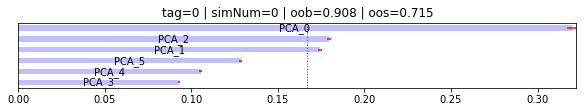

In [58]:
test_data_func(Xdot, cont, methods=['MDI']) #Can't get MDA or SFI to work, and none of them plots

### d) Do the three methods agree on what features are important? Why?

Theoretically yes?

## 2) From exercise 1, generate a new dataset (X-dot-dot,y) , where X-dot-dot is a feature union of X and X-dot .

In [80]:
Xdotdot = pd.concat([X, Xdot], axis=1)

### a) Compute MDI, MDA, and SFI feature importance on X-dot-dot, where the base estimator is RF.

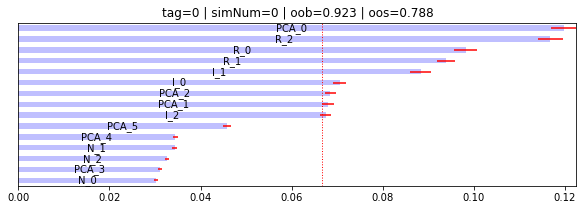

In [61]:
test_data_func(Xdotdot, cont, methods=["MDI"])

### b) Do the three methods agree on the important features? Why?

Theoretically not and MDA theoretically does worse?

## 3) Take the results from exercise 2:

### a) Drop the most important features according to each method, resulting in a features matrix X-dot-dot-dot.

In [62]:
most_important_features = ['PCA_0', 'R_2', 'R_0', 'R_1', 'I_1', 'I_0']
Xdotdotdot = Xdotdot.loc[:, ~Xdotdot.columns.isin(most_important_features)]

### b) Compute MDI, MDA, and SFI feature importance on (X-dot-dot-dot,y) , where the base estimator is RF.

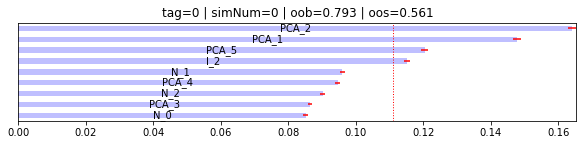

In [64]:
test_data_func(Xdotdotdot, cont, methods=["MDI"])

### c) Do you appreciate significant changes in the rankings of important features, relative to the results from exercise 2?

Not much with MDI, but can't check the others

## 4) Using the code presented in Section 8.6:

### a) Generate a dataset (X, y) of 1E6 observations, where 5 features are informative, 5 are redundant and 10 are noise

In [83]:
n_samples = 10000
X, cont = getTestData(n_features=20, n_informative=5, n_redundant=5, n_samples=n_samples)

### b) Split (X, y) into 10 datasets {(Xi, yi)}i = 1, …, 10, each of 1E5 observations.

### c) Compute the parallelized feature importance (Section 8.5), on each of the 10 datasets, {(Xi, yi)}i = 1, …, 10.

In [67]:
## Don't both, is faster and more efficient but MLdP says he prefers stacked feature importance

### d) Compute the stacked feature importance on the combined dataset (X, y).

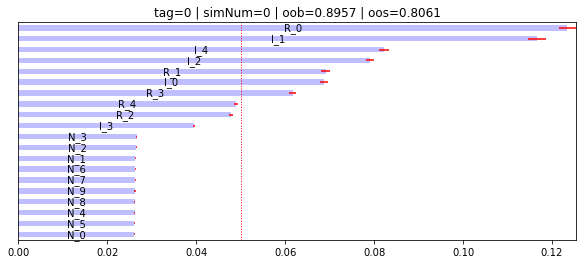

In [86]:
test_data_func(X, cont, methods=["MDI"])

### e) What causes the discrepancy between the two? Which one is more reliable?

Theoretically: Both methods generate similar rankings, with informative and redundant features above noisy ones, while the more computationally intensive (stacked) does so by a much wider margin.

In [24]:
X

,I_0,I_1,I_2,I_3,I_4,I_5,I_6,I_7,I_8,I_9,...,N_10,N_11,N_12,N_13,N_14,N_15,N_16,N_17,N_18,N_19
2017-09-04 08:59:44.384576,0.387601,-0.439806,1.010359,0.890609,3.016945,-1.010228,0.243523,-2.116744,-3.593683,-0.432650,...,1.446860,0.430600,1.067733,-1.624093,-1.187286,-1.106347,1.189328,-1.340997,0.750752,0.214460
2017-09-05 08:59:44.384576,-2.187455,-2.457017,1.997589,2.040866,0.981703,-2.990217,1.325449,1.161288,-1.927670,3.187058,...,0.247978,-0.300982,0.448604,0.955159,1.456822,-0.647968,-0.371351,1.016821,1.200919,1.080097
2017-09-06 08:59:44.384576,3.983043,0.062503,-1.311360,0.794898,0.441416,-2.218184,1.105959,1.454984,-4.171781,-2.216956,...,0.436877,-0.947405,1.300130,1.158772,0.498857,0.228109,-0.610194,-1.824205,-0.044102,2.448177
2017-09-07 08:59:44.384576,-1.503923,-1.721747,0.165340,0.426004,-0.677052,-1.512089,1.585860,4.201854,-0.552158,2.372621,...,0.994978,-1.562442,-0.336007,0.258275,0.602277,0.178423,0.726907,1.048858,-0.362107,0.674448
2017-09-08 08:59:44.384576,-1.404589,-2.624642,3.361575,-1.306431,4.578157,0.577691,4.378166,0.344652,3.416710,0.119429,...,1.085378,-0.235814,-1.658947,1.117864,1.070991,-0.382995,-0.198118,-1.398810,-0.063864,-0.114795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-28 08:59:44.384576,-0.249639,-3.052019,0.422367,-0.418817,-1.244044,-0.025354,-0.634046,-3.261394,-0.754472,1.190256,...,-0.091393,3.281322,0.746910,-0.770951,-0.665257,0.661665,0.839893,0.167732,0.226148,0.564298
2021-06-29 08:59:44.384576,-0.925248,2.049954,0.613016,2.675165,-0.474553,-0.562561,-1.590650,-2.564282,-2.024138,-3.123231,...,-0.327686,-1.923705,-0.027396,1.206699,0.503855,2.054761,-1.001365,-1.240446,-1.617521,-1.810691
2021-06-30 08:59:44.384576,-0.442937,3.257075,-0.506338,2.232121,-0.382585,-4.627209,-0.989335,-0.724105,-1.542099,0.759915,...,-0.426673,-1.259908,0.110078,-0.796126,0.088458,-0.403672,0.255454,-0.765382,1.274088,-0.901783
2021-07-01 08:59:44.384576,-1.126417,-0.486369,0.929189,1.667366,-1.132612,-0.331310,-0.785930,-1.010018,-2.692806,-3.470507,...,-0.321763,0.097716,-0.709981,-2.182884,-0.249263,0.523206,0.640408,-2.867245,0.009951,0.062721


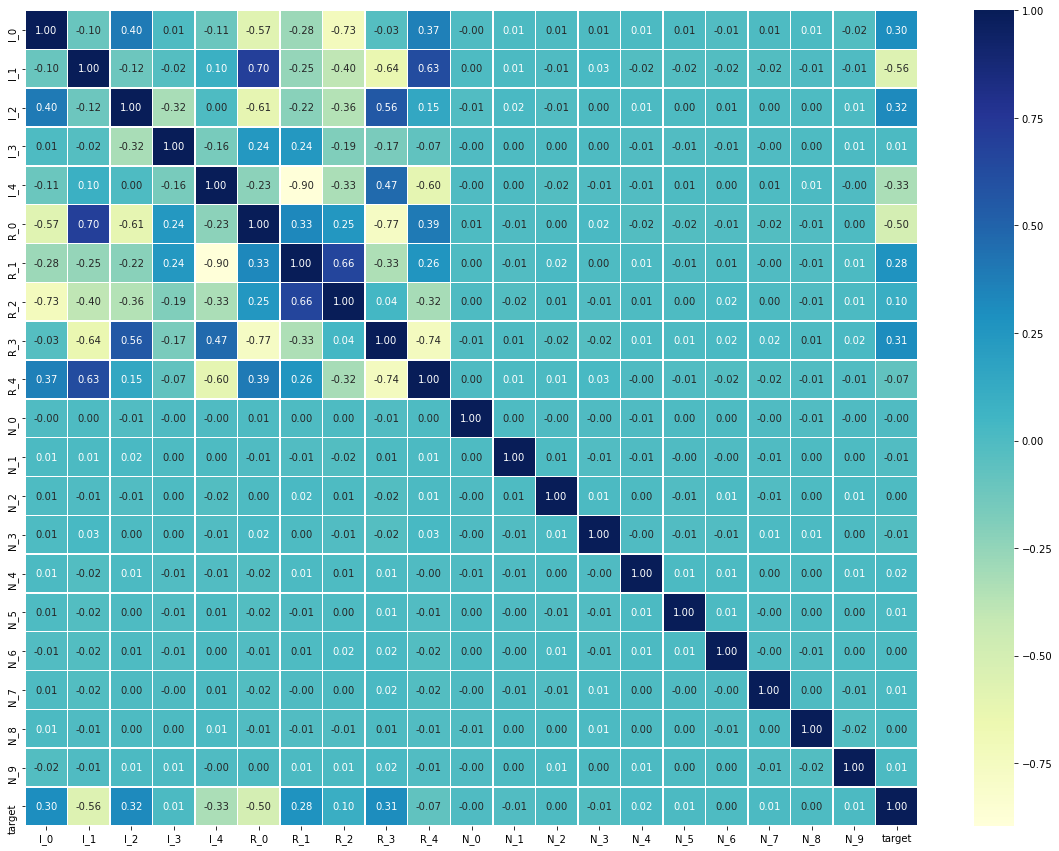

In [85]:
import seaborn as sns
indicators = list(X.columns)[:]
# indicators.append("target")

d = X[list(indicators)].copy()
d["target"] = cont.bin
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")